In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

from allen_v1dd.client import OPhysClient, EMClient
from allen_v1dd.stimulus_analysis import analysis_tools as at
at.set_stylesheet()

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
ophys_client = OPhysClient("chase")

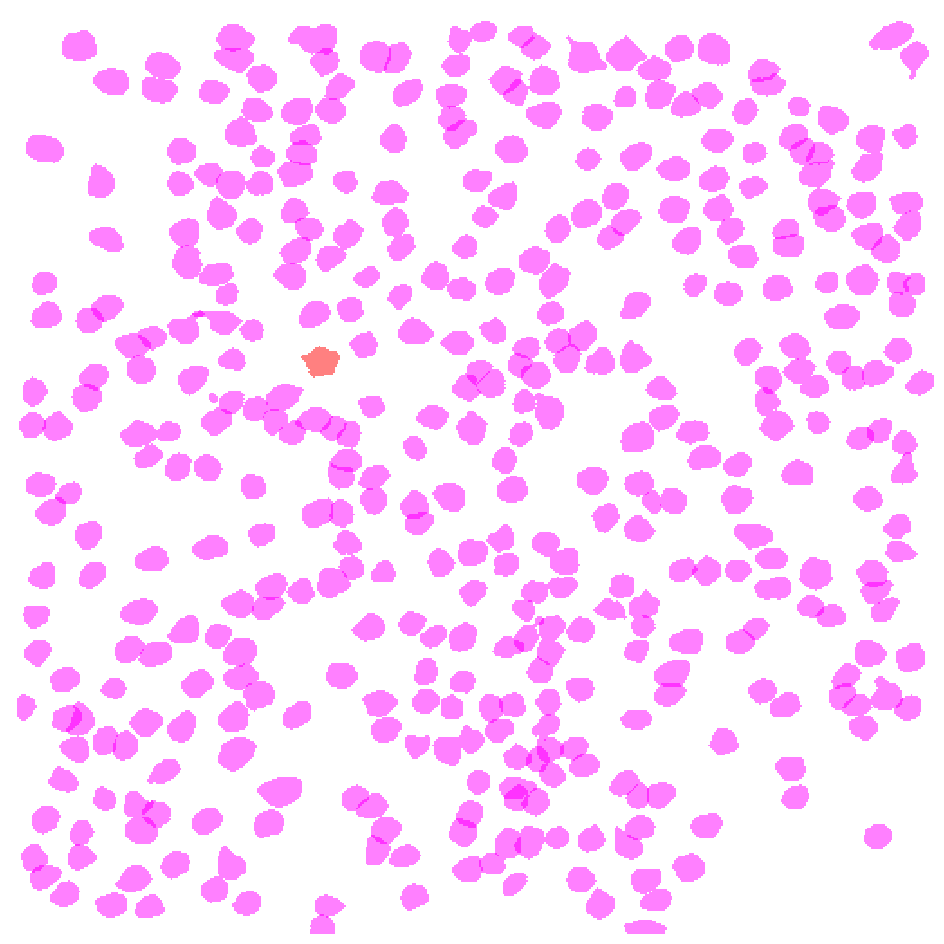

In [44]:
session = ophys_client.load_ophys_session(session_id="M409828_13")

def get_rgb():
    import random
    return (random.random(), random.random(), random.random())

plane = 0
fig, ax = plt.subplots(figsize=(12, 12))

colored_mask = None

for roi in np.where(session.is_roi_valid(plane))[0]:
    roi_mask = session.get_roi_image_mask(plane, roi)

    if colored_mask is None:
        colored_mask = np.full((*roi_mask.shape, 4), np.nan)
    
    rgb_color = get_rgb()
    rgb_color = mpl.colors.to_rgb("red" if roi == 117 else "magenta")
    already_has_roi = np.all(~np.isnan(colored_mask), axis=2)
    colored_mask[roi_mask & already_has_roi] = [*rgb_color, 0.8] # high alpha for overlapping ROIs
    colored_mask[roi_mask & ~already_has_roi] = [*rgb_color, 0.5]

ax.imshow(colored_mask, interpolation="nearest")
ax.axis("off")
fig.savefig("/Users/chase/Desktop/Plane0ROIs.png", transparent=True, bbox_inches="tight")

In [4]:
em_client = EMClient()

ConnectionError: HTTPSConnectionPool(host='globalv1.em.brain.allentech.org', port=443): Max retries exceeded with url: /info/api/v2/datastack/full/v1dd (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f7fe2790670>: Failed to establish a new connection: [Errno 61] Connection refused'))

In [ ]:
em_client.get_tables()

['functional_coregistration_v1',
 'coregistration_landmarks',
 'manual_pilot_functional_coregistration_v1',
 'correspondance_pilot',
 'ariadne_multisoma_proofreading_v1',
 'ariadne_dendrite_proofreading_v2',
 'ariadne_axon_proofreading_v1',
 'synapses_v1dd',
 'multisoma_split_task',
 'ariadne_dendrite_task',
 'ophys_examples',
 'manual_central_types',
 'nucleus_detection_v0',
 'ariadne_axon_task']

In [ ]:
coreg = em_client.get_coregistration_table()
print(len(coreg))
coreg.head()

163


,index,id,created,valid,target_id,session,scan_idx,unit_id,field,residual,...,ophys_volume,ophys_session_id,ophys_plane,ophys_roi,roi,position_microns,axon_proof_status,axon_proof_complete,dendrite_proof_status,dendrite_proof_complete
0,0,1,2023-04-14 22:08:40.446962+00:00,t,276266,1,3,117,1,NaN,...,3,M409828_13,0,117,M409828_13_0_117,"[778.7521791075498, 227.97907876189072, 29.657...",submitted,True,not_started,True
1,1,2,2023-04-14 22:08:40.447864+00:00,t,276140,1,3,75,1,NaN,...,3,M409828_13,0,75,M409828_13_0_75,"[816.1188928555765, 236.2662880987557, 17.5425...",submitted,True,submitted,True
2,2,3,2023-04-14 22:08:40.448713+00:00,t,290027,1,3,26,1,NaN,...,3,M409828_13,0,26,M409828_13_0_26,"[874.2243220704512, 248.26178219838565, -104.6...",not_started,False,not_started,False
3,3,4,2023-04-14 22:08:40.449580+00:00,t,365414,1,3,163,1,NaN,...,3,M409828_13,0,163,M409828_13_0_163,"[933.6856808451048, 252.00293174161231, -63.72...",not_started,False,not_started,False
4,4,5,2023-04-14 22:08:40.450423+00:00,t,365704,1,3,31,1,NaN,...,3,M409828_13,0,31,M409828_13_0_31,"[979.6986711301596, 251.2837669970616, -46.357...",not_started,False,not_started,False


In [7]:
# Load the corresponding 2P positions
coreg["ophys_pos"] = None

for idx, row in tqdm(coreg.iterrows(), total=len(coreg)):
    session = ophys_client.load_ophys_session(session_id=row.ophys_session_id)
    depth = session.get_plane_depth(plane=row.ophys_plane)
    y, x = np.mean(np.where(session.get_roi_image_mask(plane=row.ophys_plane, roi=row.ophys_roi)), axis=1) # note this is transposed
    coreg.at[idx, "ophys_pos"] = np.array([x, depth, y])

  0%|          | 0/163 [00:00<?, ?it/s]

(649.1711415994693, 1060.1928205622226, -136.6454103342591, 295.7220354481003)

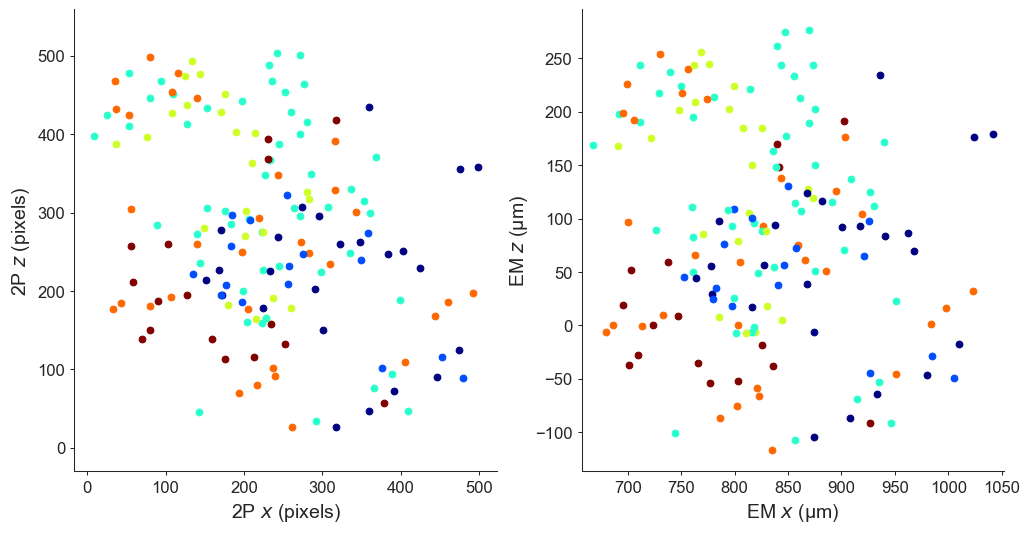

In [8]:
coreg_pts_microns = np.vstack(coreg.position_microns.values)
coreg_pts_ophys = np.vstack(coreg.ophys_pos.values)

fig, axs = plt.subplots(figsize=(12, 6), ncols=2)
axs[0].set_xlabel("2P $x$ (pixels)")
axs[0].set_ylabel("2P $z$ (pixels)")
axs[1].set_xlabel("EM $x$ (µm)")
axs[1].set_ylabel("EM $z$ (µm)")

cmap = plt.get_cmap("jet")
cmap_norm = mpl.colors.Normalize(vmin=coreg_pts_ophys[:, 1].min(), vmax=coreg_pts_ophys[:, 1].max())

for i in range(len(coreg)):
    color = cmap(cmap_norm(coreg_pts_ophys[i, 1])) # scatter.get_facecolors()[0]

    axs[0].scatter(coreg_pts_ophys[i, 0], coreg_pts_ophys[i, 2], color=color)
    axs[1].scatter(coreg_pts_microns[i, 0], coreg_pts_microns[i, 2], color=color)

axs[0].axis("equal")
axs[1].axis("equal")

# fig.colorbar(axs[1])

# Fit a transformation going from 2P space to EM space
Let P be the matrix of all 2P locations, with rows (2P x, 2P depth, 2P z). Similarly let C be the matrix of EM "cortical" locations with rows (EM x, EM depth, EM z).

We aim to find 3x3 matrix X that minimizes PX = C. The corresponding normal equation is P'PX = P'C.

We also add a bias term to offset

In [9]:
P = np.column_stack((coreg_pts_ophys, np.ones(len(coreg_pts_microns))))
C = coreg_pts_microns

np.random.seed(123)
n = len(P)
n_train = int(n * 0.75)
# n_train = n-5
rand_idx = np.random.permutation(n)

P_train, P_test = P[:n_train], P[n_train:]
C_train, C_test = C[:n_train], C[n_train:]

X = np.linalg.solve(np.matmul(P_train.T, P_train), np.matmul(P_train.T, C_train))
X

array([[ 7.52305422e-01,  5.43034737e-02,  4.00171552e-02],
       [ 2.31108668e-02,  9.24764676e-01, -2.44180824e-01],
       [ 6.77168468e-02, -3.99242368e-02,  8.08086732e-01],
       [ 6.30868963e+02,  9.22459681e+00, -7.62951611e+01]])

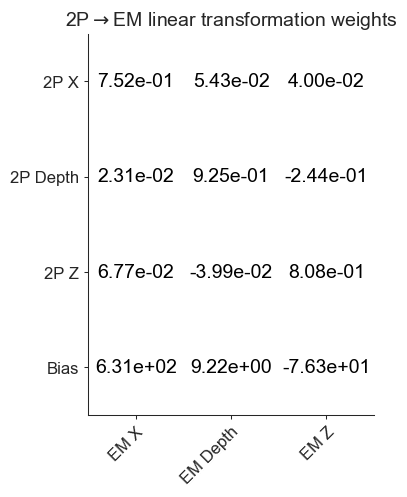

In [10]:
fig, ax = plt.subplots(figsize=(4, 6))

ax.imshow(X, cmap="hot_r", vmin=0, vmax=0) # make everything white

row_labels = ["2P X", "2P Depth", "2P Z", "Bias"]
col_labels = ["EM X", "EM Depth", "EM Z"]

ax.set_xticks(np.arange(len(col_labels)), labels=col_labels, rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(np.arange(len(row_labels)), labels=row_labels)

# Loop over data dimensions and create text annotations.
for i in range(len(row_labels)):
    for j in range(len(col_labels)):
        text = ax.text(j, i, f"{X[i, j]:.2e}", fontsize=14, ha="center", va="center", color="black")

ax.set_title("2P$\\rightarrow$EM linear transformation weights")
fig.tight_layout()

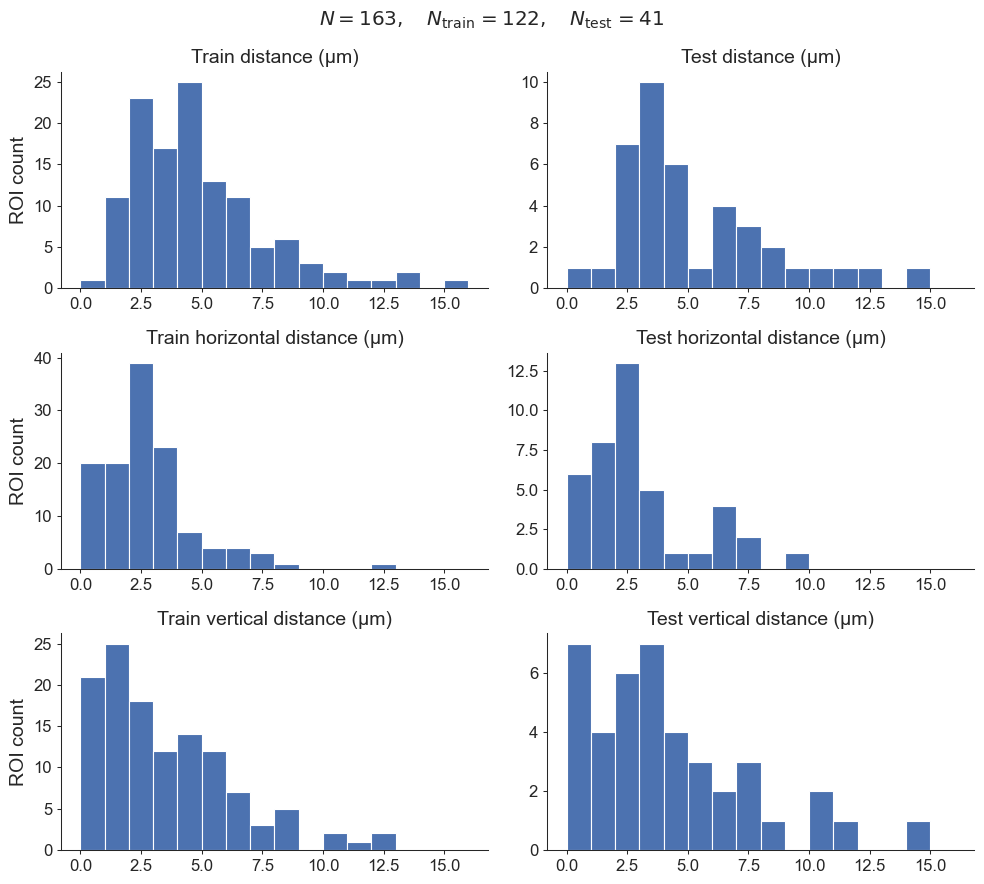

In [15]:
# Compute distance errors in microns
delta_microns = []
delta_microns_horiz = []
delta_microns_vert = []
for i in range(n):
    pi = P[i]
    ci_true = C[i]
    ci_pred = pi.dot(X)
    delta_microns.append(np.linalg.norm(ci_true - ci_pred))
    delta_microns_horiz.append(np.linalg.norm(ci_true[::2] - ci_pred[::2]))
    delta_microns_vert.append(abs(ci_true[1] - ci_pred[1]))

fig, axs = plt.subplots(figsize=(10, 9), nrows=3, ncols=2)
bins = np.arange(0, int(np.max(delta_microns))+1)

axs[0, 0].hist(delta_microns[:n_train], bins=bins)
axs[0, 0].set_title("Train distance (µm)")
axs[0, 0].set_ylabel("ROI count")
axs[0, 1].hist(delta_microns[n_train:], bins=bins)
axs[0, 1].set_title("Test distance (µm)")

ax = axs[1, 0]
ax.hist(delta_microns_horiz[:n_train], bins=bins)
ax.set_title("Train horizontal distance (µm)")
ax.set_ylabel("ROI count")
ax = axs[1, 1]
ax.hist(delta_microns_horiz[n_train:], bins=bins)
ax.set_title("Test horizontal distance (µm)")

ax = axs[2, 0]
ax.hist(delta_microns_vert[:n_train], bins=bins)
ax.set_title("Train vertical distance (µm)")
ax.set_ylabel("ROI count")
ax = axs[2, 1]
ax.hist(delta_microns_vert[n_train:], bins=bins)
ax.set_title("Test vertical distance (µm)")

fig.suptitle(f"$N = {n}, \quad N_\\operatorname{{train}} = {n_train}, \quad N_\\operatorname{{test}} = {n-n_train}$")
fig.tight_layout()

(649.4552297610697, 1054.226969168612, -138.50214037936524, 295.8104511645339)

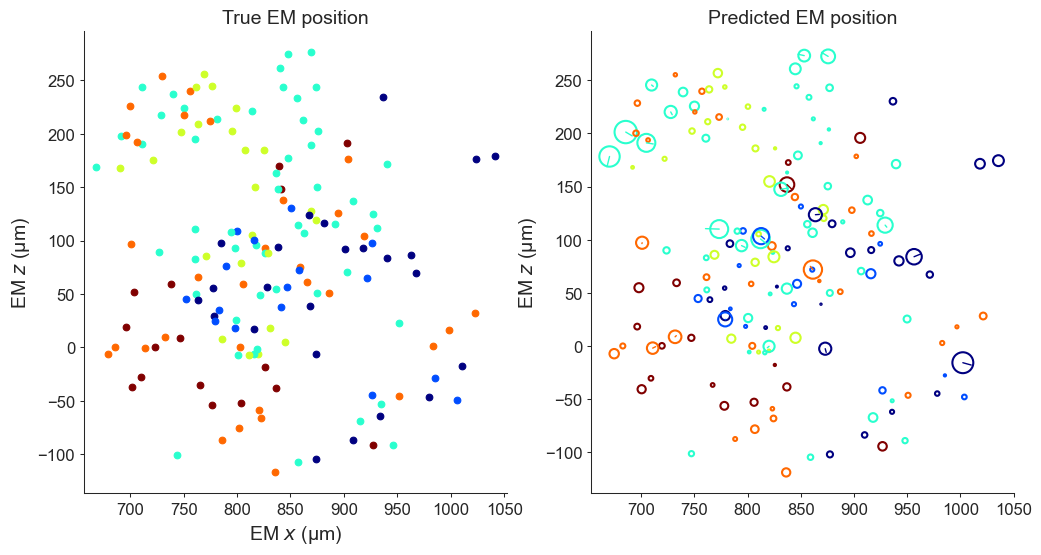

In [13]:
# Width (not area) of point is proportional to the prediction error in microns
fig, axs = plt.subplots(figsize=(12, 6), ncols=2)
# axs[0].set_xlabel("True EM $x$ (µm)")
# axs[0].set_ylabel("True EM $z$ (µm)")
# axs[1].set_xlabel("Predicted EM $x$ (µm)")
# axs[1].set_ylabel("Predicted EM $z$ (µm)")
axs[0].set_xlabel("EM $x$ (µm)")
axs[0].set_ylabel("EM $z$ (µm)")
axs[1].set_ylabel("EM $z$ (µm)")
axs[0].set_title("True EM position")
axs[1].set_title("Predicted EM position")

cmap = plt.get_cmap("jet")
cmap_norm = mpl.colors.Normalize(vmin=coreg_pts_ophys[:, 1].min(), vmax=coreg_pts_ophys[:, 1].max())

for i in range(len(coreg)):
    pi = P[i]
    ci_true = C[i]
    ci_pred = pi.dot(X)
    delta_microns = np.linalg.norm(ci_true - ci_pred)
    color = cmap(cmap_norm(pi[1]))

    axs[0].scatter(ci_true[0], ci_true[2], color=color)
    # axs[1].scatter(ci_pred[0], ci_pred[2], color=color)
    # axs[1].scatter(ci_pred[0], ci_pred[2], color=color, s=delta_microns**2)
    axs[1].scatter(ci_pred[0], ci_pred[2], color="none", edgecolor=color, linewidth=1.5, s=delta_microns**2)
    if delta_microns > 8:
        axs[1].plot([ci_true[0], ci_pred[0]], [ci_true[2], ci_pred[2]], color=color, linestyle="solid", linewidth=1)

axs[0].axis("equal")
axs[1].axis("equal")



(649.1711415994693, 1060.1928205622226, -138.50214037936524, 295.8104511645339)

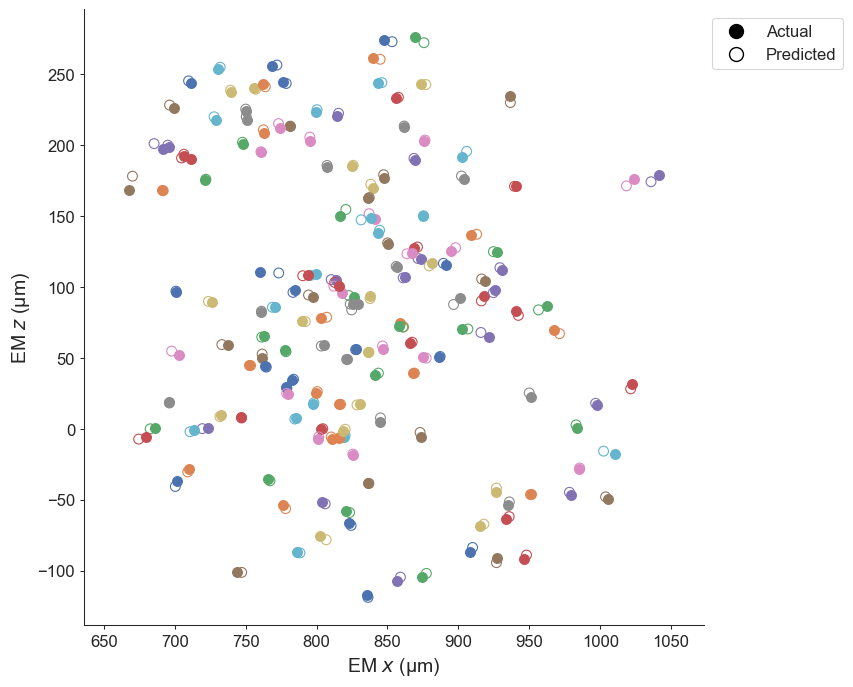

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlabel("EM $x$ (µm)")
ax.set_ylabel("EM $z$ (µm)")

# cmap = plt.get_cmap("jet")
# cmap_norm = mpl.colors.Normalize(vmin=coreg_pts_ophys[:, 1].min(), vmax=coreg_pts_ophys[:, 1].max())

for i in range(len(coreg)):
    pi = P[i]
    ci_true = C[i]
    ci_pred = pi.dot(X)
    delta_microns = np.linalg.norm(ci_true - ci_pred)
    color = cmap(cmap_norm(pi[1]))

    color = ax.scatter(ci_true[0], ci_true[2], s=50).get_facecolors()[0]
    ax.scatter(ci_pred[0], ci_pred[2], facecolors="none", edgecolors=color, s=50)

    # axs[0].scatter(ci_true[0], ci_true[2], color=color)
    # axs[1].scatter(ci_pred[0], ci_pred[2], color=color)
    # axs[1].scatter(ci_pred[0], ci_pred[2], color=color, s=delta_microns**2)

ax.legend(handles=[
    mpl.lines.Line2D([0], [0], label="Actual", marker="o", color="none", markerfacecolor="black", markersize=10),
    mpl.lines.Line2D([0], [0], label="Predicted", marker="o", color="none", markeredgecolor="black", markersize=10)
], loc="upper left", bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)
ax.axis("equal")

# For the cells in train/test, measure the distance to other nearby cells (as margin of error)

In [32]:
nearby = em_client.get_nearby_cells(pt_root_id=coreg.pt_root_id.values[0], radius_microns=500, drop_duplicates=True)
nearby

,level_0,index,id,created,superceded_id,valid,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position,position_microns,dist_to_center
0,0,0,205343,2022-02-04 06:22:21.810242+00:00,NaN,t,248.192017,88325213242236740,864691132846889171,"[663170, 596278, 375615]","[658824, 592398, 40017]","[668291, 599926, 40963]","[666.5220206708693, 286.48699608858027, 202.29...",214.058257
1,1,1,440200,2022-02-04 06:24:17.749098+00:00,NaN,t,341.939710,101769353493617160,864691132903653870,"[1139013, 731302, 119430]","[1134202, 726414, 12382]","[1143979, 735493, 13367]","[1142.6653446016448, 345.63643251082493, -80.6...",398.060929
2,2,2,249935,2022-02-04 06:24:45.834987+00:00,NaN,t,218.123352,88336071053971528,864691132592758071,"[663635, 987926, 428895]","[659755, 982416, 45886]","[667748, 992426, 46550]","[668.9363496871065, 678.0973147080539, 148.786...",478.390741
3,3,3,352748,2022-02-04 06:21:51.961180+00:00,NaN,t,327.581606,96344088714040956,864691132683790367,"[947186, 482129, 280665]","[942762, 476852, 29784]","[951997, 487561, 30700]","[949.8605274454524, 149.6747684474694, 141.362...",218.832157
4,4,14,310800,2022-02-04 06:28:11.759005+00:00,NaN,t,117.923644,91709166502637335,864691132736081579,"[782984, 823103, 415440]","[778871, 816973, 44426]","[787252, 828380, 45134]","[787.4754527859229, 515.0956110101034, 179.944...",324.188179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55736,86457,127741,291364,2022-02-04 06:21:21.405001+00:00,NaN,t,438.984136,90580860675690911,864691132826821552,"[743641, 734484, 150885]","[738519, 729983, 15714]","[749306, 739140, 16786]","[747.3554159691884, 359.09031029009407, -51.23...",157.223978
55737,86458,127745,200433,2022-02-04 06:25:11.400678+00:00,NaN,t,322.057153,89942044352960292,864691132997583541,"[720982, 537535, 133200]","[716093, 533190, 13886]","[726026, 542114, 14841]","[723.7285659477452, 164.70996683770844, -15.55...",95.260500
55738,86460,127756,373117,2022-02-04 06:25:07.445108+00:00,NaN,t,255.271349,96915148102655435,864691132733276187,"[967284, 774603, 466425]","[963482, 770413, 49742]","[971630, 778561, 50750]","[971.6084991502554, 481.0966794481466, 242.051...",382.587356
55739,86461,127761,385527,2022-02-04 06:22:22.057055+00:00,NaN,t,327.498416,95371021326033837,864691132771793533,"[912188, 918939, 416520]","[907222, 914671, 44460]","[917465, 923595, 45318]","[917.138920075658, 607.0789652204668, 155.3305...",422.683402


In [33]:
nearby_positions = np.vstack(nearby.position_microns.values)

In [62]:
n, n_train

(163, 122)

(array([18., 13., 16., 10., 14., 22., 22., 24., 22.,  2.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

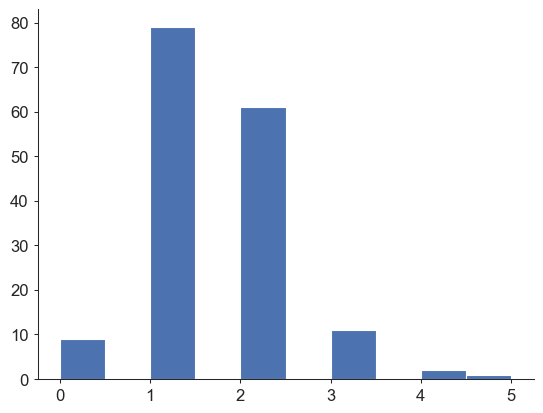

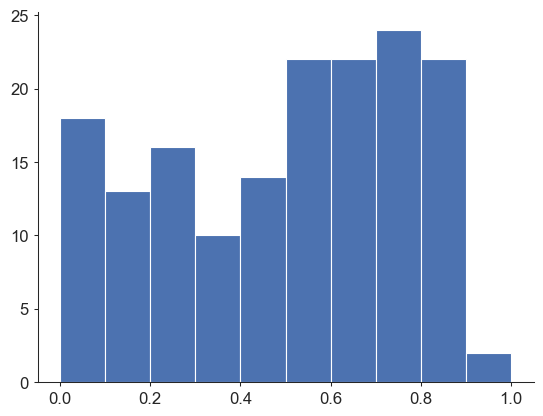

In [53]:
n_soma_nearby_of_pred = []
score = []
is_correct = []
for i in range(n):
    pi = P[i]
    ci_true = C[i]
    ci_pred = pi.dot(X)
    pred_err_dist = np.linalg.norm(ci_true - ci_pred)
    pred_err_horiz_dist = np.linalg.norm(ci_true[::2] - ci_pred[::2])
    pred_err_vert_dist = abs(ci_true[1] - ci_pred[1])

    nearby_dist = np.linalg.norm(nearby_positions - ci_pred, axis=1)
    nearby_horiz_dist = np.linalg.norm(nearby_positions[:, ::2] - ci_pred[::2], axis=1)
    n_soma_nearby_of_pred.append(np.count_nonzero(nearby_dist <= 10))
    closest_dist, second_closest_dist = np.partition(nearby_dist, 2)[:2]

    # score.append(nearby_dist.min() / pred_err_horiz_dist)
    score.append(1 - closest_dist / second_closest_dist)

    is_correct.append(pred_err_dist == closest_dist)


plt.hist(n_soma_nearby_of_pred)
plt.figure()
plt.hist(score, bins=np.arange(0, 1.1, 0.1))

In [67]:
np.array(is_correct)[:n_train][np.array(score)[:n_train] > 0.5]#.mean()
# np.array(is_correct)[n_train:][np.array(score)[n_train:] > 0.5]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

# Plot column boundaries in EM (from Marc Takeno)

In [16]:
EM_CENTER = (212574, 5674)
EM_COLUMN_BOUNDS = {
	1: ((256581, 9733), (160660, 1772)),
	2: ((212015, 5637), (117303, 14196)),
	3: ((212574, 5674), (120280, -20)),
	4: ((212574, 5674), (305983, 14382)),
	5: ((212574, 5674), (303751, 129))
}

# Transform according to scale
for col, (bound_1, bound_2) in EM_COLUMN_BOUNDS.keys():
    EM_COLUMN_BOUNDS[key] = (())

COLUMN_COLORS = {
    1: 'r',
    2: 'g',
    3: 'b',
    4: 'm',
    5: 'k'
}

# (212574, 89829, 5674)				center
# (117675, 89829, 14270)				column 2 outside corner
# (213132, 89829, 14308)				column 2 - 4 common corner
# (119908, 89829, 5562)				column 2 - 3 common corner
# (305983, 89829, 14382)				column 4 outside corner
# (304123, 89829, 5748)				column 4 - 5 common corner

<AxesSubplot: >

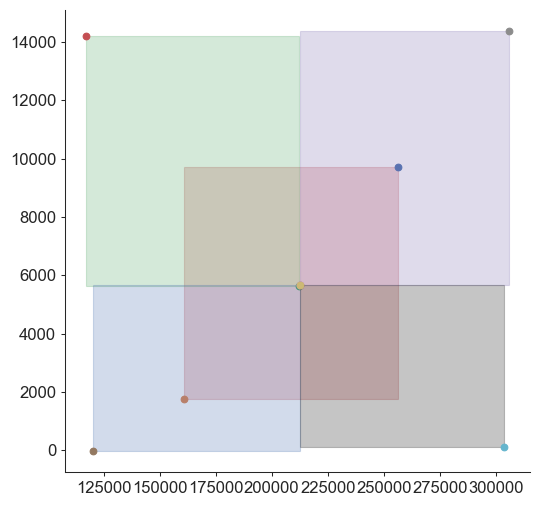

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))

for col, (bound_1, bound_2) in EM_COLUMN_BOUNDS.items():
    ax.add_artist(plt.Rectangle(xy=bound_1, width=(bound_2[0] - bound_1[0]), height=(bound_2[1] - bound_1[1]), color=COLUMN_COLORS[col], alpha=0.25))
    ax.scatter(*bound_1)
    ax.scatter(*bound_2)

# ax.legend()
ax.axis("equal")